In [161]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

class DataFetcher1:
    def __init__(self, ticker_symbol):
        self.ticker_symbol = ticker_symbol
        self.ticker = yf.Ticker(ticker_symbol)
        self.all_data = None
    
    def get_info(self):
        """Get basic company information"""
        return self.ticker.info
        
    def get_income_statement(self):
        """Get income statement data"""
        return self.ticker.income_stmt

    def get_balance_sheet(self):
        """Get balance sheet data"""
        return self.ticker.balance_sheet

    def get_cash_flow(self):
        """Get cash flow statement data"""
        return self.ticker.cashflow

    def get_share_price_data(self, period="max"):
        """Get historical share price data"""
        share_price_data = self.ticker.history(period=period)
        share_price_data.reset_index(inplace=True)
        return share_price_data
    
    def get_dividends(self):
        """Get dividend data"""
        return self.ticker.dividends
    
    def get_summary(self):
        """Get a summary of key metrics"""
        info = self.get_info()
        summary = {
            'company_name': info.get('longName', 'N/A'),
            'sector': info.get('sector', 'N/A'),
            'industry': info.get('industry', 'N/A'),
            'market_cap': info.get('marketCap', 'N/A'),
            'current_price': info.get('currentPrice', 'N/A'),
            'pe_ratio': info.get('trailingPE', 'N/A'),
            'eps': info.get('trailingEps', 'N/A'),
            'dividend_yield': info.get('dividendYield', 'N/A')
        }
        return summary
    
    def calculate_pe_ratio(self, price, earnings_per_share):
        """Calculate P/E ratio"""
        if earnings_per_share == 0 or earnings_per_share is None or price is None:
            return None
        return price / earnings_per_share

    def get_comprehensive_data(self):
        """
        Get all financial data and combine into a comprehensive DataFrame
        
        Returns:
            pandas.DataFrame: Combined data from all sources
        """
        try:
            # Initialize data dictionary
            data_dict = {}
            
            # 1. Get basic info and summary
            info = self.get_info()
            summary = self.get_summary()
            data_dict['info'] = info
            data_dict['summary'] = summary
            
            # 2. Get financial statements
            income_stmt = self.get_income_statement()
            balance_sheet = self.get_balance_sheet()
            cash_flow = self.get_cash_flow()
            
            data_dict['income_statement'] = income_stmt
            data_dict['balance_sheet'] = balance_sheet
            data_dict['cash_flow'] = cash_flow
            
            # 3. Get market data
            share_price_data = self.get_share_price_data()
            dividends = self.get_dividends()
            
            data_dict['share_price_data'] = share_price_data
            data_dict['dividends'] = dividends
            
            # 4. Create enhanced income statement with additional metrics
            enhanced_income_stmt = self._create_enhanced_income_statement(income_stmt, share_price_data, dividends)
            data_dict['enhanced_income_statement'] = enhanced_income_stmt
            
            # 5. Combine everything into a master DataFrame
            combined_df = self._create_combined_dataframe(enhanced_income_stmt, balance_sheet, cash_flow, summary)
            
            self.all_data = data_dict
            return combined_df
            
        except Exception as e:
            print(f"Error fetching comprehensive data for {self.ticker_symbol}: {e}")
            return None
    
    def _create_enhanced_income_statement(self, income_stmt, share_price_data, dividends):
        """Create enhanced income statement with share price, dividends, and P/E ratio"""
        enhanced_is = income_stmt.copy()
        
        # Add ticker symbol
        enhanced_is.loc['Ticker'] = [self.ticker_symbol] * len(enhanced_is.columns)
        
        # Add share prices
        share_prices = []
        for date_str in enhanced_is.columns:
            fiscal_date = pd.to_datetime(date_str).date()
            mask = share_price_data['Date'].dt.date <= fiscal_date
            if mask.any():
                last_row = share_price_data[mask].iloc[-1]
                share_prices.append(last_row['Close'])
            else:
                share_prices.append(None)
        enhanced_is.loc['Share Price'] = share_prices
        
        # Add dividends
        dividend_values = []
        dividends_df = dividends.reset_index() if dividends is not None else pd.DataFrame()
        
        for date_str in enhanced_is.columns:
            fiscal_date = pd.to_datetime(date_str).date()
            if not dividends_df.empty:
                dividends_df['Date'] = pd.to_datetime(dividends_df['Date']).dt.date
                mask = dividends_df['Date'] <= fiscal_date
                if mask.any():
                    last_div = dividends_df[mask].iloc[-1]['Dividends']
                    dividend_values.append(last_div)
                else:
                    dividend_values.append(0.0)
            else:
                dividend_values.append(0.0)
        enhanced_is.loc['Dividends'] = dividend_values
        
        # Add P/E ratios
        pe_ratios = []
        for col in enhanced_is.columns:
            share_price = enhanced_is.loc["Share Price", col]
            
            # Try different EPS column names
            eps = None
            for eps_name in ["Basic EPS", "Diluted EPS", "Earnings Per Share"]:
                if eps_name in enhanced_is.index:
                    eps = enhanced_is.loc[eps_name, col]
                    break
            
            pe = self.calculate_pe_ratio(share_price, eps)
            pe_ratios.append(pe)
        enhanced_is.loc["P/E Ratio"] = pe_ratios
        
        return enhanced_is
    
    def _create_combined_dataframe(self, enhanced_income_stmt, balance_sheet, cash_flow, summary):
        """Combine all data into a single DataFrame"""
        # Start with enhanced income statement as base
        combined_df = enhanced_income_stmt.copy()
        
        # Add key balance sheet items if they exist
        balance_sheet_items = ['Total Assets', 'Total Liabilities Net Minority Interest', 
                              'Total Equity Gross Minority Interest', 'Current Assets', 
                              'Current Liabilities']
        
        for item in balance_sheet_items:
            if item in balance_sheet.index:
                combined_df.loc[item] = balance_sheet.loc[item]
        
        # Add key cash flow items if they exist
        cash_flow_items = ['Operating Cash Flow', 'Investing Cash Flow', 
                          'Financing Cash Flow', 'Free Cash Flow']
        
        for item in cash_flow_items:
            if item in cash_flow.index:
                combined_df.loc[item] = cash_flow.loc[item]
        
        # Add summary metrics as new rows
        combined_df.loc['Summary_MarketCap'] = [summary['market_cap']] * len(combined_df.columns)
        combined_df.loc['Summary_CurrentPrice'] = [summary['current_price']] * len(combined_df.columns)
        combined_df.loc['Summary_Sector'] = [summary['sector']] * len(combined_df.columns)
        combined_df.loc['Summary_Industry'] = [summary['industry']] * len(combined_df.columns)
        
        return combined_df
    
    def display_data_overview(self):
        """Display an overview of all fetched data"""
        if self.all_data is None:
            print("No data available. Run get_comprehensive_data() first.")
            return
        
        print(f"\n{'='*50}")
        print(f"DATA OVERVIEW FOR {self.ticker_symbol}")
        print(f"{'='*50}")
        
        summary = self.all_data['summary']
        print(f"Company: {summary['company_name']}")
        print(f"Sector: {summary['sector']}")
        print(f"Industry: {summary['industry']}")
        print(f"Market Cap: ${summary['market_cap']:,.2f}")
        print(f"Current Price: ${summary['current_price']:.2f}")
        print(f"P/E Ratio: {summary['pe_ratio']}")
        
        print(f"\nFinancial Statements:")
        print(f"- Income Statement: {self.all_data['income_statement'].shape}")
        print(f"- Balance Sheet: {self.all_data['balance_sheet'].shape}")
        print(f"- Cash Flow: {self.all_data['cash_flow'].shape}")
        print(f"- Share Price Data Points: {len(self.all_data['share_price_data'])}")
        print(f"- Dividend Payments: {len(self.all_data['dividends']) if self.all_data['dividends'] is not None else 0}")



In [162]:
# Example usage
if __name__ == "__main__":
    # Create fetcher instance
    fetcher = DataFetcher1("AAPL")
    
    # Get all data in one comprehensive DataFrame
    comprehensive_df = fetcher.get_comprehensive_data()
    
    # Display overview
    fetcher.display_data_overview()
    
    # Show the combined DataFrame
    if comprehensive_df is not None:
        print(f"\nCombined DataFrame shape: {comprehensive_df.shape}")
        print("\nFirst few rows of combined data:")
        print(comprehensive_df.head())


DATA OVERVIEW FOR AAPL
Company: Apple Inc.
Sector: Technology
Industry: Consumer Electronics
Market Cap: $3,744,081,903,616.00
Current Price: $252.29
P/E Ratio: 38.341946

Financial Statements:
- Income Statement: (39, 4)
- Balance Sheet: (68, 4)
- Cash Flow: (53, 4)
- Share Price Data Points: 11304
- Dividend Payments: 88

Combined DataFrame shape: (56, 4)

First few rows of combined data:
                                                        2024-09-30  \
Tax Effect Of Unusual Items                                    0.0   
Tax Rate For Calcs                                           0.241   
Normalized EBITDA                                   134661000000.0   
Net Income From Continuing Operation Net Minori...   93736000000.0   
Reconciled Depreciation                              11445000000.0   

                                                        2023-09-30  \
Tax Effect Of Unusual Items                                    0.0   
Tax Rate For Calcs                          

In [163]:
comprehensive_df.index

Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Total Operating Income As Reported',
       'Diluted Average Shares', 'Basic Average Shares', 'Diluted EPS',
       'Basic EPS', 'Diluted NI Availto Com Stockholders',
       'Net Income Common Stockholders', 'Net Income',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Other Income Expense', 'Other Non Operating Income Expenses',
       'Net Non Operating Interest Income Expense',
       'Interest Expense Non Operating', 'Interest Income Non Operating',
       'Operating Inco

In [164]:
comprehensive_df.head(100)

,2024-09-30,2023-09-30,2022-09-30,2021-09-30
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0
Tax Rate For Calcs,0.241,0.147,0.162,0.133
Normalized EBITDA,134661000000.0,125820000000.0,130541000000.0,123136000000.0
Net Income From Continuing Operation Net Minority Interest,93736000000.0,96995000000.0,99803000000.0,94680000000.0
Reconciled Depreciation,11445000000.0,11519000000.0,11104000000.0,11284000000.0
Reconciled Cost Of Revenue,210352000000.0,214137000000.0,223546000000.0,212981000000.0
EBITDA,134661000000.0,125820000000.0,130541000000.0,123136000000.0
EBIT,123216000000.0,114301000000.0,119437000000.0,111852000000.0
Net Interest Income,NaN,-183000000.0,-106000000.0,198000000.0
Interest Expense,NaN,3933000000.0,2931000000.0,2645000000.0


In [165]:
comprehensive_simple_df = comprehensive_df.copy()
rows_to_keep = [
    'Ticker',
    'P/E Ratio',
    'Basic EPS',
    'Free Cash Flow',
    'Operating Cash Flow',
    'Investing Cash Flow',   # optional, used for capex adjustments in DCF
    'Dividends',
    'Net Income',
    'Diluted EPS',
    'Share Price',           # optional for P/E
    'Total Assets',
    'Total Liabilities Net Minority Interest',
    'Total Equity Gross Minority Interest',
    'Basic Average Shares',  # optional to convert totals to per-share
    'Diluted Average Shares' # optional to convert totals to per-share
]
comprehensive_simple_df = comprehensive_simple_df.loc[rows_to_keep]
comprehensive_simple_df

,2024-09-30,2023-09-30,2022-09-30,2021-09-30
Ticker,AAPL,AAPL,AAPL,AAPL
P/E Ratio,37.957549,27.524235,22.122336,24.431186
Basic EPS,6.11,6.16,6.15,5.67
Free Cash Flow,108807000000.0,99584000000.0,111443000000.0,92953000000.0
Operating Cash Flow,118254000000.0,110543000000.0,122151000000.0,104038000000.0
Investing Cash Flow,2935000000.0,3705000000.0,-22354000000.0,-14545000000.0
Dividends,0.25,0.24,0.23,0.22
Net Income,93736000000.0,96995000000.0,99803000000.0,94680000000.0
Diluted EPS,6.08,6.13,6.11,5.61
Share Price,231.920624,169.549286,136.052368,138.524826


In [166]:
comprehensive_simple_df = comprehensive_simple_df.dropna(axis=1, how='any')
comprehensive_simple_df

,2024-09-30,2023-09-30,2022-09-30,2021-09-30
Ticker,AAPL,AAPL,AAPL,AAPL
P/E Ratio,37.957549,27.524235,22.122336,24.431186
Basic EPS,6.11,6.16,6.15,5.67
Free Cash Flow,108807000000.0,99584000000.0,111443000000.0,92953000000.0
Operating Cash Flow,118254000000.0,110543000000.0,122151000000.0,104038000000.0
Investing Cash Flow,2935000000.0,3705000000.0,-22354000000.0,-14545000000.0
Dividends,0.25,0.24,0.23,0.22
Net Income,93736000000.0,96995000000.0,99803000000.0,94680000000.0
Diluted EPS,6.08,6.13,6.11,5.61
Share Price,231.920624,169.549286,136.052368,138.524826


In [167]:

comprehensive_df = comprehensive_simple_df

# Discounted Cash Flow Calculation for intrinsic value
# FCFL = Free Cash Flow Latest
# FCFE = Free Cash Flow Earliest
FCFL = comprehensive_df.loc["Free Cash Flow"].iloc[0]
FCFE = comprehensive_df.loc["Free Cash Flow"].iloc[-1]
N = n_years = len(comprehensive_df.columns) - 1
if FCFE <= 0:
    print("Cannot calculate CAGR for DCF: negative or zero FCF.")
else:
    if FCFL <= 0:
        print("Cannot calculate CAGR for DCF: negative or zero FCF.")
    else:
        CAGR = (FCFL / FCFE) ** (1 / N) - 1
        discount_rate = 0.10
        terminal_growth_rate = 0.025
        projection_years = 5
        FCF1=FCFE * (1 + CAGR) ** 1
        FCF2=FCFE * (1 + CAGR) ** 2
        FCF3=FCFE * (1 + CAGR) ** 3 
        FCF4=FCFE * (1 + CAGR) ** 4
        FCF5=FCFE * (1 + CAGR) ** 5
        PV_FCF1 = FCF1 / (1 + discount_rate) ** 1
        PV_FCF2 = FCF2 / (1 + discount_rate) ** 2  
        PV_FCF3 = FCF3 / (1 + discount_rate) ** 3
        PV_FCF4 = FCF4 / (1 + discount_rate) ** 4
        PV_FCF5 = FCF5 / (1 + discount_rate) ** 5
        TV = FCF5 * (1 + terminal_growth_rate) / (discount_rate - terminal_growth_rate)
        PV_TV = TV / (1 + discount_rate) ** projection_years
        PV_total_FCF = PV_FCF1 + PV_FCF2 + PV_FCF3 + PV_FCF4 + PV_FCF5
        EV = PV_total_FCF + PV_TV
        shares_outstanding = comprehensive_df.loc["Basic Average Shares"].iloc[-1]  # or Diluted Average Shares
        DCF_value_per_share = EV / shares_outstanding

        print("DCF Intrinsic Value per Share:", round(DCF_value_per_share, 2))

DCF Intrinsic Value per Share: 85.92


In [168]:
#Dividend Discount Model for intrinsic value 
# (a) Constant Growth DDM (Gordon Growth Model)
dividends_row = comprehensive_df.loc["Dividends"]

# Check if the company pays any dividends
if dividends_row.sum() != 0:
    D_earliest = dividends_row.iloc[0]
    D_latest = dividends_row.iloc[-1]
    n_years = len(dividends_row) - 1

    current_dividend = D_latest  # usually use the most recent dividend
    dividend_growth_rate = (D_latest / D_earliest) ** (1 / n_years) - 1
    dividend_next_year = current_dividend * (1 + dividend_growth_rate)

    required_rate_return = 0.10
    intrinsic_value_ddm = dividend_next_year / (required_rate_return - dividend_growth_rate)

    projection_years = 5
    dividends_projection = [D_latest * (1 + dividend_growth_rate)**t for t in range(1, projection_years + 1)]
    PV_dividends = sum([div / (1 + required_rate_return)**t for t, div in enumerate(dividends_projection, start=1)])
    terminal_growth = 0.03
    terminal_dividends = dividends_projection[-1] * (1 + terminal_growth)

    PV_terminal = terminal_dividends / ((required_rate_return - terminal_growth) * (1 + required_rate_return)**projection_years)
    DDM_multi_stage = PV_dividends + PV_terminal

    print("DDM Intrinsic Value per Share:", round(intrinsic_value_ddm, 2))
    print("Multi-Stage DDM Intrinsic Value:", round(DDM_multi_stage, 2))
else:
    print("Company does not pay dividends")




DDM Intrinsic Value per Share: 1.49
Multi-Stage DDM Intrinsic Value: 2.37


In [169]:
#Earnings Multiplier (P/E) Model
EPS = comprehensive_df.loc["Diluted EPS"].iloc[0]

# Estimate expected P/E as historical average
pe_row = comprehensive_df.loc["P/E Ratio"].dropna()
expected_PE = pe_row.mean()

PE_value = EPS * expected_PE
print("P/E Model Intrinsic Value:", round(PE_value, 2))


P/E Model Intrinsic Value: 170.29


In [170]:
#Asset-Based Valuation Model
total_assets = comprehensive_df.loc["Total Assets"].iloc[0]
total_liabilities = comprehensive_df.loc["Total Liabilities Net Minority Interest"].iloc[0]
shares_outstanding = comprehensive_df.loc["Basic Average Shares"].iloc[0]

asset_value_per_share = (total_assets - total_liabilities) / shares_outstanding
print("Asset-Based Intrinsic Value per Share:", round(asset_value_per_share, 2))


Asset-Based Intrinsic Value per Share: 3.71


In [171]:
#Modern Graham Value Model

EPS = comprehensive_df.loc["Diluted EPS"].iloc[0]

# Calculate g from historical EPS
eps_row = comprehensive_df.loc["Diluted EPS"].dropna()
n_years = len(eps_row) - 1
g = ((eps_row.iloc[0] / eps_row.iloc[-1]) ** (1 / n_years) - 1) * 100

# Set current AAA corporate bond yield
Y = 5.21

# Modern Graham Value
Graham_value = EPS * (8.5 + 2 * g) * (4.4 / Y)
print("Modern Graham Value per Share:", round(Graham_value, 2))


Modern Graham Value per Share: 71.56


In [172]:
print("DCF Intrinsic Value per Share:", round(DCF_value_per_share, 2))
print("DDM Intrinsic Value per Share:", round(intrinsic_value_ddm, 2))
print("Multi-Stage DDM Intrinsic Value:", round(DDM_multi_stage, 2))
print("P/E Model Intrinsic Value:", round(PE_value, 2))
print("Asset-Based Intrinsic Value per Share:", round(asset_value_per_share, 2))
print("Modern Graham Value per Share:", round(Graham_value, 2))

DCF Intrinsic Value per Share: 85.92
DDM Intrinsic Value per Share: 1.49
Multi-Stage DDM Intrinsic Value: 2.37
P/E Model Intrinsic Value: 170.29
Asset-Based Intrinsic Value per Share: 3.71
Modern Graham Value per Share: 71.56


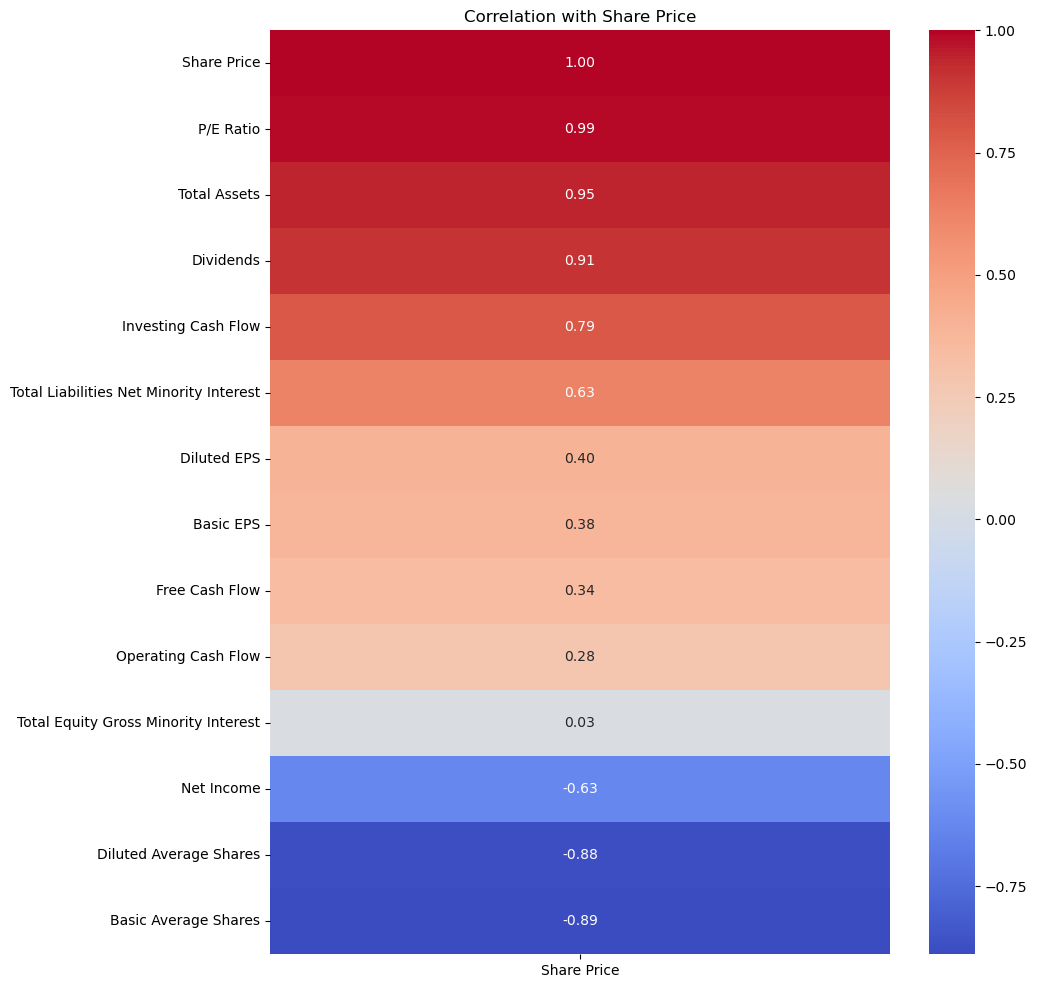

In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make a copy of your DataFrame and ensure numeric values only
comprehensive_df = comprehensive_df.apply(pd.to_numeric, errors='coerce').dropna(how='all')
comprehensive_df = comprehensive_df.T
# Compute correlation matrix
corr_matrix = comprehensive_df.corr()

# Optional: focus on correlations with Share Price
target_corr = corr_matrix[['Share Price']].sort_values(by='Share Price', ascending=False)

# Plot heatmap of correlations with Share Price
plt.figure(figsize=(10, 12))
sns.heatmap(target_corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation with Share Price")
plt.show()


In [174]:
corr_with_price = comprehensive_df.corr()['Share Price'].sort_values(ascending=False)
corr_with_price

Share Price                                1.000000
P/E Ratio                                  0.992187
Total Assets                               0.947837
Dividends                                  0.907528
Investing Cash Flow                        0.787196
Total Liabilities Net Minority Interest    0.626245
Diluted EPS                                0.400717
Basic EPS                                  0.383732
Free Cash Flow                             0.343498
Operating Cash Flow                        0.278382
Total Equity Gross Minority Interest       0.029479
Net Income                                -0.626834
Diluted Average Shares                    -0.880218
Basic Average Shares                      -0.889425
Name: Share Price, dtype: float64